In [2]:
pip install slycot

     |████████████████████████████████| 1.6MB 21.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417829 sha256=93cdea4bc85cc942d802b167c56d1305a1ed7b10cdf1ee8bb98464f5e36e838b
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot


In [3]:
pip install control

     |████████████████████████████████| 348kB 15.6MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=2557a1c672a0668a04695cc65eeb92993931a7a95177cc961bdb4d4b71441c64
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


LQR eig: [14.65940308 31.10693327 -0.08028552]
place eig: [29.04   9.954 18.94 ]


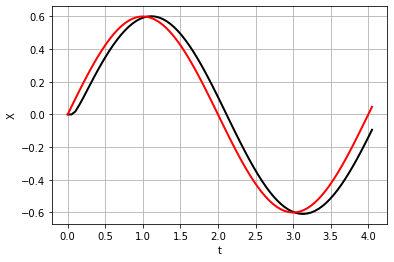

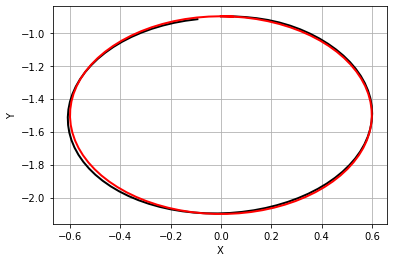

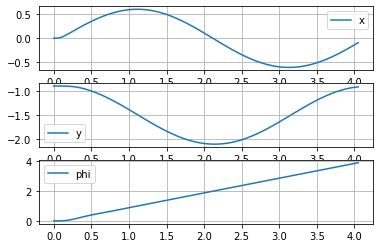

In [8]:
from scipy.integrate import odeint
from scipy.spatial.transform import Rotation
import math
import numpy as np
import matplotlib.pyplot as plt
import control
import control.matlab

#Two-Step modelling

J = 0.015
d = 0.089
r = 0.1
Kt = 0.026
Rr = 4.3
M = 1.5
l = 5
s3 = math.sqrt(3)
B = (l*Kt/(r*Rr))*np.array([[-s3/(2*M), 0, s3/(2*M)],
                            [1/(2*M), 1/M, 1/(2*M)],
                            [d/J, d/J, d/J]])

mu = 10 #np.diag(np.array([10,1,1]))
Vy = 0.07
x0 = 0
y0 = -0.9
dc = 1
pc = 0
ph0 = 0.01
Y0 = np.array([0,0,0,x0,y0,ph0])
Z0 = np.array([0,0,0,x0,y0,ph0,0,0,0])

A = np.array([[-0.48,0,0],
              [0,-0.53,0],
              [0,0,-0.023]])

K1 = 1*np.eye(3,3)
K2 = 1*np.diag([1,1,1])

Q = 1*np.diag(np.array([40,1,1]))
Kd,KdS,KdE = control.lqr(A,B,Q,1e-2*np.eye(3))
Kd = np.asarray(Kd)
w,v = np.linalg.eig(A + B @ Kd)
print(f"LQR eig: {w}")

p = 10*np.array([-1,-2,-3])
Kd = control.matlab.place(A,B,p)
Kd = np.asarray(Kd)
w,v = np.linalg.eig(A + B @ Kd)
print(f"place eig: {w}")

Kv = np.linalg.inv(B@Kd) @ (-A+B@Kd)


#equilibrium theta
th0 = 0
R0 = np.array([[math.cos(th0), -math.sin(th0),0],
               [math.sin(th0), math.cos(th0),0],
               [0,0,1]]).T
#F(0)
F = np.linalg.inv(B)@((A-B@Kd)@R0.T@K2 - R0.T@K1)
#disturbance
h = np.array([0.1,0.1,0.1])
#h = np.array([0,0,0])
dt = 0.05
T = 4
npoints = 20*T+1
tau0 = np.array([0.0, 0.0, 0.0])
# tau0 = np.array([-0.24275397, 0.48436653, -0.24145355])
t_int = np.array([0, dt])
tt = np.linspace(0,T+dt,npoints)
y_log = Y0
zn_log = Y0[3:6]

t = 0
Vd = np.array([0,0,0])
vd_log = Vd

# Robot dynamics right part
def dy(y, t, tau, v0):
    V = y[0:3]
    n = y[3:6]
    theta = n[2]

    R = np.array([[math.cos(theta), -math.sin(theta),0],
				  [math.sin(theta), math.cos(theta),0],
				  [0,0,1]])

    dV   = A @ V  + B @ tau + dc*h
    dn   = R @ V

    return np.concatenate((dV,dn))

# Regulator dynamics right part
def dz(y, t, n, tau):
    zv = y[0:3]
    zn = y[3:6]
    p = y[6:9]
    theta = n[2]
    eps = n - zn

    R = np.array([[math.cos(theta), -math.sin(theta),0],
				  [math.sin(theta), math.cos(theta),0],
				  [0,0,1]])

    dzv  = A @ zv + B @ tau + R.T @ K1 @ eps
    dzn  = R @ zv + K2 @ eps
    dp   = -p + F@eps

    return np.concatenate((dzv,dzn,dp))

# Iterate through all time points
for i in range(0,npoints-1):
    # Integrate dynamics
    Y = odeint(dy, Y0, t_int, args=(tau0, Vd))
    Y0 = Y[-1,:]
    n = Y0[3:6]
    zn_log = np.vstack((zn_log, n))
    t += dt
    y_log = np.vstack((y_log,Y0))

    x, y, phi = n[0], n[1], n[2]
    
    # Integrate regulator
    Z = odeint(dz, Z0, t_int, args=(n, tau0))
    Z0 = Z[-1,:]
    zv = Z0[0:3]
    p = Z0[6:9]
    radius = 0.6

    e = n - radius*np.array([math.sin(2*math.pi*t/4),
                        (math.cos(2*math.pi*t/4)+y0/radius-1),
                        t/radius])

    R = np.array([[math.cos(phi), -math.sin(phi),0],
                    [math.sin(phi), math.cos(phi),0],
                    [0,0,1]])
    Vd = -mu * R.T @ e

    vd_log = np.vstack((vd_log,Vd))

    # Get control signal
    tau0  = -Kd @ (zv - Kv@Vd) + pc*p

radius = 0.6
plt.figure(1)
plt.plot(tt, y_log[:,3],c='k',label='traj',linewidth=2)
plt.xlabel('t')
plt.ylabel('X')
y_ideal = radius*(np.cos(2*math.pi*tt/4)+y0/radius-1)
x_ideal = radius*np.sin(2*math.pi*tt/4)
plt.plot(tt, x_ideal, c='r',label='ideal',linewidth=2)
plt.grid(True)

plt.figure(2)
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(y_log[:,3], y_log[:,4],c='k',label='traj',linewidth=2)
plt.plot(x_ideal, y_ideal, c='r',label='ideal',linewidth=2)
plt.grid(True)
plt.show()


plt.subplot(3,1,1)
plt.plot(tt, y_log[:,3],label='x')
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(tt, y_log[:,4],label='y')
plt.legend()
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(tt, y_log[:,5],label='phi')
plt.legend()
#plt.ylim(-0.05,0.05)
plt.grid(True)
plt.show()


LQR eig: [14.65940308 31.10693327 -0.08028552]
place eig: [20.04   6.954 12.94 ]


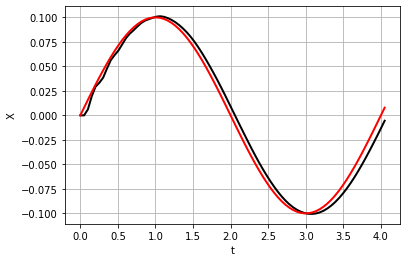

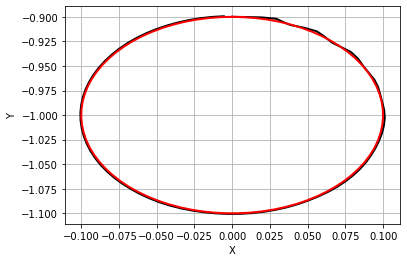

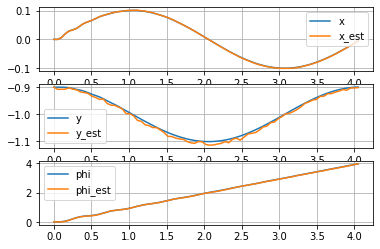

In [16]:
from scipy.integrate import odeint
from scipy.spatial.transform import Rotation
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2
import control
import control.matlab

#ArUco marker draw on the blank bg image

marker_size = 110
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)
marker_image = cv2.aruco.drawMarker(dictionary, 0, marker_size);
img_center = tuple((np.array(marker_image.shape)-1) / 2)
rot_max_side = int(round(marker_size*math.sqrt(2)))
rot_size = (rot_max_side, rot_max_side)
rot_shift = rot_max_side/2.0 - marker_size/2.0
bg_img_sz = (10000, 10000)
    
def draw_marker(bg_img, x, y, phi, scale=1.0, pp = False):
    phi_rad = phi
    phi = math.degrees(phi)
    rot_mat = cv2.getRotationMatrix2D(img_center, phi, scale)

    rot_max_side = int(round(marker_size*math.sqrt(2)))
    if (pp != False):
        rot_max_side = int(1.2*scale*(marker_size*(1+(math.sqrt(2)-1)*math.sin(2*phi_rad))))

    rot_shift = rot_max_side/2.0 - marker_size/2.0
    rot_mat[1,2] += rot_shift   #alpha+
    rot_mat[0,2] += rot_shift   #betha+

    
    rot_size = (rot_max_side, rot_max_side)

    result = cv2.warpAffine(marker_image, rot_mat, rot_size, flags=cv2.INTER_LINEAR, borderValue=255)
    cnt_x = int(x - rot_max_side/2)
    cnt_y = int(y - rot_max_side/2)
    bg_img[cnt_y:cnt_y+rot_max_side,cnt_x:cnt_x+rot_max_side] = result
    return bg_img

#Two-Step modelling

J = 0.015
d = 0.089
r = 0.1
Kt = 0.026
Rr = 4.3
M = 1.5
l = 5
s3 = math.sqrt(3)
B = (l*Kt/(r*Rr))*np.array([[-s3/(2*M), 0, s3/(2*M)],
                            [1/(2*M), 1/M, 1/(2*M)],
                            [d/J, d/J, d/J]])

mu = 30
Vy = 0.07
x0 = 0
y0 = -0.9
dc = 1
pc = 1
ph0 = 0.01
Y0 = np.array([0,0,0,x0,y0,ph0])
Z0 = np.array([0,0,0,x0,y0,ph0,0,0,0])
A = np.array([[-0.48,0,0],
              [0,-0.53,0],
              [0,0,-0.023]])

K1 = 30*np.eye(3,3)
K2 = 30*np.diag([1,1,1])

# Kd = np.array([[-3.8106, -0.0012, 0.5733],
# 			   [-0.0000, 0.0083, 0.5727],
# 			   [3.8106, -0.0012, 0.5733]])

# Kv = np.array([[1.3608, -0.0000, -0.0000],
# 			   [0.0000, 831.2001, -2.6982],
# 			   [0.0000, -2.7928, 1.0165]])

Q = 1*np.diag(np.array([40,1,1]))
Kd,KdS,KdE = control.lqr(A,B,Q,1e-2*np.eye(3))
Kd = np.asarray(Kd)
w,v = np.linalg.eig(A + B @ Kd)
print(f"LQR eig: {w}")

p = 7*np.array([-1,-2,-3])
Kd = control.matlab.place(A,B,p)
Kd = np.asarray(Kd)
w,v = np.linalg.eig(A + B @ Kd)
print(f"place eig: {w}")

Kv = np.linalg.inv(B@Kd) @ (-A+B@Kd)

#equilibrium theta
th0 = 0
R0 = np.array([[math.cos(th0), -math.sin(th0),0],
               [math.sin(th0), math.cos(th0),0],
               [0,0,1]]).T

#F(0)
F = np.linalg.inv(B)@((A-B@Kd)@R0.T@K2 - R0.T@K1)

#disturbance
#h = np.array([0.1,0.1,0.1])
h = np.array([0,0,0])
dt = 0.05
T = 4
npoints = 81
tau0 = np.array([0.0, 0.0, 0.0])
t_int = np.array([0, dt])
tt = np.linspace(0,T+dt,npoints)

y_log = Y0
zn_log = Y0[3:6]
t = 0

Vd = np.array([0,0,0])
vd_log = Vd

# Robot dynamics right part
def dy(y, t, tau, v0):
    V = y[0:3]
    n = y[3:6]
    theta = n[2]

    R = np.array([[math.cos(theta), -math.sin(theta),0],
				  [math.sin(theta), math.cos(theta),0],
				  [0,0,1]])

    dV   = A @ V  + B @ tau + h
    dn   = R @ V

    return np.concatenate((dV,dn))

# Regulator dynamics right part
def dz(y, t, n, tau):
    zv = y[0:3]
    zn = y[3:6]
    p = y[6:9]
    theta = n[2]
    eps = n - zn

    R = np.array([[math.cos(theta), -math.sin(theta),0],
				  [math.sin(theta), math.cos(theta),0],
				  [0,0,1]])

    dzv  = A @ zv + B @ tau + R.T @ K1 @ eps
    dzn  = R @ zv + K2 @ eps
    dp   = -p + F@eps

    return np.concatenate((dzv,dzn,dp))

hg = 1.5
distCoeffs = np.zeros([0,0,0,0])
bg_img_cnt = (bg_img_sz[0]-1)/2
bg_img_sz_half = bg_img_sz[0]/2
cameraMatrix = np.array([[1,0,bg_img_cnt],[0,1,bg_img_cnt],[0,0,1]])
markerLength = hg*marker_size/bg_img_sz_half

# Iterate through all time points
for i in range(0,npoints-1):
    # Integrate dynamics
    Y = odeint(dy, Y0, t_int, args=(tau0, Vd))
    Y0 = Y[-1,:]
    zv = Z0[0:3]
    n = Y0[3:6]
    p = Z0[6:9]
    t += dt
    y_log = np.vstack((y_log,Y0))

    x, y, phi = n[0], n[1], n[2]
    img_x = bg_img_cnt + bg_img_sz_half*x/hg
    img_y = bg_img_cnt - bg_img_sz_half*y/hg

    # !!! Here goes ArUco marker draw+detection !!!
    marker = 255 * np.ones(bg_img_sz, dtype=np.uint8)
    marker = draw_marker(marker, img_x, img_y, phi)
    
    parameters = cv2.aruco.DetectorParameters_create()
    corners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(marker, dictionary, parameters=parameters)
    rvecs, tvecs, _objPoints = cv2.aruco.estimatePoseSingleMarkers(corners, markerLength, cameraMatrix, distCoeffs)
    rvec = rvecs[0][0]
    tvec = tvecs[0][0]
    r = Rotation.from_rotvec(rvec)
    angles = r.as_euler('zxy')
    x_est = tvec[0]
    y_est = -tvec[1]
    phi_est = np.pi + angles[0] - 0.01

    n_estim = np.array([x_est,y_est,phi_est]) #this should be replaced by estimate from detection
    zn_log = np.vstack((zn_log,n_estim))
    n_estim = n
    
    # Integrate regulator
    Z = odeint(dz, Z0, t_int, args=(n_estim, tau0))
    Z0 = Z[-1,:]
    zv = Z0[0:3]
    p = Z0[6:9]

    radius = 0.1
    e = n - radius*np.array([math.sin(2*math.pi*t/4),
                        (math.cos(2*math.pi*t/4)+y0/radius-1),
                        t/radius])
    R = np.array([[math.cos(phi), -math.sin(phi),0],
                    [math.sin(phi), math.cos(phi),0],
                    [0,0,1]])
    
    Vd = -mu * R.T @ e
    vd_log = np.vstack((vd_log,Vd))

    # Get control signal
    tau0  = -Kd @ (zv - Kv@Vd) #+ pc*p

radius = 0.1
plt.figure(1)
plt.plot(tt, y_log[:,3],c='k',label='traj',linewidth=2)
plt.xlabel('t')
plt.ylabel('X')
y_ideal = radius*(np.cos(2*math.pi*tt/4)+y0/radius-1)
x_ideal = radius*np.sin(2*math.pi*tt/4)
plt.plot(tt, x_ideal, c='r',label='ideal',linewidth=2)
plt.grid(True)

plt.figure(2)
plt.xlabel('X')
plt.ylabel('Y')
plt.plot(y_log[:,3], y_log[:,4],c='k',label='traj',linewidth=2)
plt.plot(x_ideal, y_ideal, c='r',label='ideal',linewidth=2)
plt.grid(True)
plt.show()

plt.subplot(3,1,1)
plt.plot(tt, y_log[:,3],label='x')
plt.plot(tt, zn_log[:,0],label='x_est')
plt.legend()
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(tt, y_log[:,4],label='y')
plt.plot(tt, zn_log[:,1],label='y_est')
plt.legend()
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(tt, y_log[:,5],label='phi')
plt.plot(tt, zn_log[:,2],label='phi_est')
plt.legend()
#plt.ylim(-0.05,0.05)
plt.grid(True)
plt.show()